# Project Kojak - Crunchbase
#### Daniel Shin

In [61]:
from pycrunchbase import *
import pandas as pd
import numpy as np
from collections import Counter
from pymongo import MongoClient
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import json
from urllib2 import urlopen
%matplotlib inline
client = MongoClient()

In [2]:
# initiate a kojak database and collection with documents related to crunch_ppl

db = client.kojak
crunch_ppl = db.crunch_ppl
orgs_api = db.orgs_api

In [3]:
# use pycrunchbase wrapper to access crunchbase API using key

cb_api_key = "f724cd5232dd318067da50fd13ec28bc"
cb = CrunchBase(cb_api_key)

In [4]:
# read in data from open data map

orgs_odm_df = pd.read_csv("/Users/DanShin/Downloads/Data/odm/organizations.csv")
ppl_odm_df = pd.read_csv("/Users/DanShin/Downloads/Data/odm/people.csv")

In [5]:
# preprocess data

orgs_odm_df = orgs_odm_df.drop("type", axis = 1)
orgs_odm_df = orgs_odm_df.drop("profile_image_url", axis = 1)

ppl_odm_df = ppl_odm_df.drop("type", axis = 1)
ppl_odm_df["name"] = ppl_odm_df.first_name + " " + ppl_odm_df.last_name

# combine names and insert to index 1
ppl_odm_df = ppl_odm_df.drop(["first_name", "last_name"], axis = 1)
columns = ppl_odm_df.columns.tolist()
columns.remove("name")
columns.insert(1, "name")
ppl_odm_df  = ppl_odm_df[columns]
ppl_odm_df = ppl_odm_df.drop("profile_image_url", axis = 1)


In [6]:
ppl_odm_df.columns

Index([u'crunchbase_uuid', u'name', u'crunchbase_url', u'facebook_url', u'twitter_url', u'linkedin_url', u'location_city', u'location_region', u'location_country_code', u'title', u'organization', u'organization_crunchbase_url'], dtype='object')

In [7]:
ppl_odm_df.organization_crunchbase_url

0                                                       NaN
1                                                       NaN
2              https://www.crunchbase.com/organization/zoho
3              https://www.crunchbase.com/organization/zoho
4                                                       NaN
5            https://www.crunchbase.com/organization/fflick
6          https://www.crunchbase.com/organization/facebook
7             https://www.crunchbase.com/organization/asana
8              https://www.crunchbase.com/organization/boku
9         https://www.crunchbase.com/organization/benchmark
10             https://www.crunchbase.com/organization/jumo
11                                                      NaN
12        https://www.crunchbase.com/organization/safetyweb
13            https://www.crunchbase.com/organization/ellie
14        https://www.crunchbase.com/organization/photob...
15        https://www.crunchbase.com/organization/photob...
16          https://www.crunchbase.com/o

In [8]:
ppl_odm_df.columns

Index([u'crunchbase_uuid', u'name', u'crunchbase_url', u'facebook_url', u'twitter_url', u'linkedin_url', u'location_city', u'location_region', u'location_country_code', u'title', u'organization', u'organization_crunchbase_url'], dtype='object')

In [4]:
# load in tabs of crunchbase_export.xls file as different dataframes
# companies (companies and aggregated funding information)
# rounds (summarized version of investments for each round - can disregard and just use investments)
# investments (info on company, their investments, funding round, amount raised)
# acquisitions (info on company, their acquirer, the price amount and currency)


# companies = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Companies")
rounds = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Rounds")
investments = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Investments")
acquisitions = pd.read_excel(io="/Users/DanShin/Downloads/Data/crunchbase_export.xlsx", sheetname="Acquisitions")

In [12]:
max(investments.funded_at)

Timestamp('2015-06-11 00:00:00')

In [738]:
Counter(rounds.funding_round_type)

Counter({u'venture': 45465, u'seed': 25045, u'debt_financing': 6217, u'angel': 5105, u'undisclosed': 4339, u'equity_crowdfunding': 2840, u'private_equity': 1904, u'grant': 1852, u'convertible_note': 1264, u'post_ipo_equity': 515, u'product_crowdfunding': 284, u'non_equity_assistance': 139, u'post_ipo_debt': 122, u'secondary_market': 73})

In [740]:
acquisitions.columns

Index([u'company_permalink', u'company_name', u'company_category_list', u'company_market', u'company_country_code', u'company_state_code', u'company_region', u'company_city', u'acquirer_permalink', u'acquirer_name', u'acquirer_category_list', u'acquirer_market', u'acquirer_country_code', u'acquirer_state_code', u'acquirer_region', u'acquirer_city', u'acquired_at', u'acquired_month', u'acquired_quarter', u'acquired_year', u'price_amount', u'price_currency_code'], dtype='object')

In [8]:
top_categories = Counter(investments.company_market).most_common(30)
top_categories = [str(cat[0]) for cat in top_categories]

In [9]:
comps_subset = investments[investments.company_market.isin(top_categories)]

In [10]:
market = top_categories[0][0]
num_per_round = Counter(investments.funding_round_code[investments.company_market == market])
fund_round_counts = num_per_round.items()
fund_round_counts = [x for x in fund_round_counts if type(x[0]) == unicode]  # remove nans
fund_rounds = [str(r[0]) for r in fund_round_counts]
fund_counts = [r[1] for r in fund_round_counts]

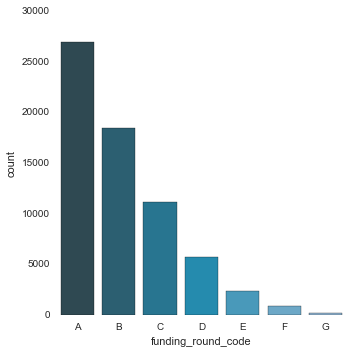

In [11]:
# funding round code

sns.factorplot("funding_round_code", data=investments, x_order=list("ABCDEFG"), palette="PuBuGn_d");

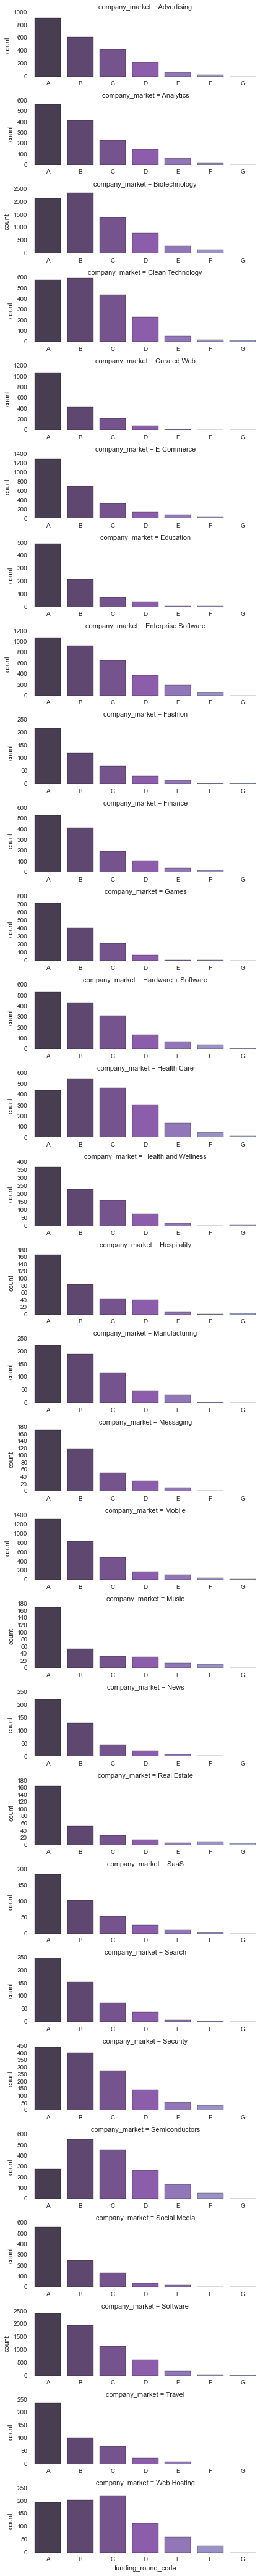

In [12]:
# histogram of investments spread across funding rounds by market

sns.factorplot("funding_round_code", data=comps_subset, row="company_market", x_order=list("ABCDEFG"),
               margin_titles=False, aspect=3, size=2, palette="BuPu_d", sharex = False, sharey = False);

In [13]:
num_acquired = sum(companies.status == "acquired")/float(len(companies.status))
num_ipo = sum(companies.status == "ipo")/float(len(companies.status))

print "Total Percent Acquired: " + str(round(num_acquired* 100, 1)) + "%"
print "Total Percent IPO: " + str(round(num_ipo* 100, 1)) + "%"

Total Percent Acquired: 7.6%
Total Percent IPO: 2.4%


In [14]:
avg_rounds_acquired = np.mean(companies[companies.status == "acquired"].funding_rounds)
avg_rounds_ipo = np.mean(companies[companies.status == "ipo"].funding_rounds)

print "Average # Rounds Acquired: " + str(round(avg_rounds_acquired, 2))
print "Average # Rounds IPO: " + str(round(avg_rounds_ipo, 2))

Average # Rounds Acquired: 2.04
Average # Rounds IPO: 2.67


In [430]:
Counter(companies[companies.status == "ipo"].market)
Counter(companies[companies.status == "ipo"].market)

Counter({u'Biotechnology': 415, u'Software': 91, u'Health Care': 59, u'Clean Technology': 49, u'Hardware + Software': 44, u'Mobile': 39, u'Semiconductors': 35, u'E-Commerce': 34, u'Manufacturing': 25, u'Games': 25, u'Curated Web': 24, u'Finance': 24, u'Health and Wellness': 22, u'Enterprise Software': 22, nan: 20, u'Web Hosting': 20, u'Security': 20, u'Advertising': 20, u'Technology': 13, u'Pharmaceuticals': 11, u'Banking': 11, u'Real Estate': 9, u'Public Relations': 9, u'Search': 8, u'Travel': 8, u'Consulting': 8, u'Financial Services': 8, u'Internet': 7, u'Education': 7, u'Hospitality': 7, u'Information Technology': 7, u'Medical Devices': 7, u'Wireless': 7, u'Photography': 6, u'Business Services': 6, u'Automotive': 6, u'Electronics': 6, u'Medical': 6, u'News': 5, u'Fashion': 5, u'Telecommunications': 5, u'Transportation': 5, u'Retail': 5, u'Analytics': 5, u'Entertainment': 4, u'Messaging': 4, u'Pets': 3, u'Solar': 3, u'Services': 3, u'Social Media': 3, u'Public Transportation': 3, u'

In [427]:
companies.columns

Index([u'permalink', u'name', u'homepage_url', u'category_list', u'market', u'funding_total_usd', u'status', u'country_code', u'state_code', u'region', u'city', u'funding_rounds', u'founded_at', u'founded_month', u'founded_quarter', u'founded_year', u'first_funding_at', u'last_funding_at'], dtype='object')

In [444]:
pd.to_datetime(companies.founded_at) - pd.to_datetime(companies.last_funding_at)

TypeError: ufunc subtract cannot use operands with types dtype('O') and dtype('<M8[ns]')

In [474]:
a = pd.to_datetime(companies.founded_at)
b = companies.last_funding_at.apply(lambda x: datetime.utcfromtimestamp(x))

TypeError: a float is required

In [532]:
Counter(companies.founded_at.astype(datetime).apply(lambda x: type(x)))

Counter({<type 'datetime.datetime'>: 43605, <type 'float'>: 11953, <type 'unicode'>: 86})

In [531]:
Counter(companies.last_funding_at.apply(lambda x: type(x)))

Counter({<class 'pandas.tslib.Timestamp'>: 55644})

In [540]:
list(companies.founded_at[companies.founded_at.apply(lambda x: type(x)) == unicode].astype(datetime))

u'1871-01-01'

In [554]:
investments.columns

Index([u'company_permalink', u'company_name', u'company_category_list', u'company_market', u'company_country_code', u'company_state_code', u'company_region', u'company_city', u'investor_permalink', u'investor_name', u'investor_category_list', u'investor_market', u'investor_country_code', u'investor_state_code', u'investor_region', u'investor_city', u'funding_round_permalink', u'funding_round_type', u'funding_round_code', u'funded_at', u'funded_month', u'funded_quarter', u'funded_year', u'raised_amount_usd'], dtype='object')

Early stage startups: which ones affect your growth.
Try to find out what makes early stage startups successful and categorize them.
What are the characteristics of each startup or fund?
Do a vertical barplot for each industry, broken down by percent of funding in each category.
Do an analysis of raised_amount_usd by funded_year
Do an analysis of raised_amount_usd by funded_month
Do an analysis of average time to IPO/acquisition by year of exit
Investor market

In [547]:
investments.columns

Index([u'company_permalink', u'company_name', u'company_category_list', u'company_market', u'company_country_code', u'company_state_code', u'company_region', u'company_city', u'investor_permalink', u'investor_name', u'investor_category_list', u'investor_market', u'investor_country_code', u'investor_state_code', u'investor_region', u'investor_city', u'funding_round_permalink', u'funding_round_type', u'funding_round_code', u'funded_at', u'funded_month', u'funded_quarter', u'funded_year', u'raised_amount_usd'], dtype='object')

In [562]:
rounds.head()

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
0,/organization/-fame,#fame,|Media|,Media,IND,NaN,Mumbai,Mumbai,/funding-round/9a01d05418af9f794eebff7ace91f638,venture,B,2015-01-05,2015-01,2015-Q1,2015,10000000
1,/organization/hashoff,#HASHOFF,|Digital Media|Internet|Social Media|,Digital Media,USA,CO,Denver,Denver,/funding-round/669d6203c0374e6cf0e8d10f75ba0b8a,debt_financing,NaN,2014-12-08,2014-12,2014-Q4,2014,455000
2,/organization/waywire,#waywire,|Entertainment|Politics|Social Media|News|,News,USA,NY,New York City,New York,/funding-round/cc409188fa2b63482bd9008f682c2efa,seed,NaN,2012-06-30,2012-06,2012-Q2,2012,1750000
3,/organization/tv-communications,&TV Communications,|Games|,Games,USA,CA,Los Angeles,Los Angeles,/funding-round/59a3669a64e39360c2b939300bcda162,venture,NaN,2010-09-23,2010-09,2010-Q3,2010,3000000
4,/organization/tv-communications,&TV Communications,|Games|,Games,USA,CA,Los Angeles,Los Angeles,/funding-round/86d22afc65107b6941e6c43c671ecbb8,venture,NaN,2010-06-04,2010-06,2010-Q2,2010,1000000


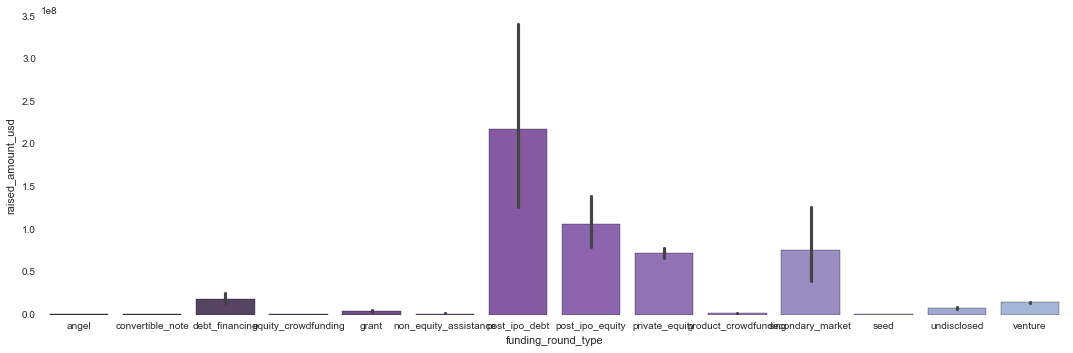

In [568]:
sns.factorplot("funding_round_type", "raised_amount_usd", data=,
               margin_titles=False, aspect=3, size=5, palette="BuPu_d", sharex = False, sharey = False);

In [570]:
Counter(investments.funding_round_type)

Counter({u'venture': 94041, u'seed': 43335, u'angel': 8306, u'debt_financing': 6831, u'undisclosed': 5646, u'private_equity': 2941, u'equity_crowdfunding': 2856, u'grant': 1923, u'convertible_note': 1692, u'post_ipo_equity': 585, u'product_crowdfunding': 292, u'non_equity_assistance': 140, u'post_ipo_debt': 134, u'secondary_market': 81})

In [577]:
investments.columns

Index([u'company_permalink', u'company_name', u'company_category_list', u'company_market', u'company_country_code', u'company_state_code', u'company_region', u'company_city', u'investor_permalink', u'investor_name', u'investor_category_list', u'investor_market', u'investor_country_code', u'investor_state_code', u'investor_region', u'investor_city', u'funding_round_permalink', u'funding_round_type', u'funding_round_code', u'funded_at', u'funded_month', u'funded_quarter', u'funded_year', u'raised_amount_usd'], dtype='object')

In [578]:
acquisitions.columns

Index([u'company_permalink', u'company_name', u'company_category_list', u'company_market', u'company_country_code', u'company_state_code', u'company_region', u'company_city', u'acquirer_permalink', u'acquirer_name', u'acquirer_category_list', u'acquirer_market', u'acquirer_country_code', u'acquirer_state_code', u'acquirer_region', u'acquirer_city', u'acquired_at', u'acquired_month', u'acquired_quarter', u'acquired_year', u'price_amount', u'price_currency_code'], dtype='object')

In [598]:
market_sim = acquisitions.acquirer_market == acquisitions.company_market
market_diff = acquisitions.acquirer_market != acquisitions.company_market

In [601]:
acq = acquisitions[market_sim]
acq2 = acquisitions[market_diff]
print (np.mean(acq[acq.price_currency_code == "USD"].price_amount))
print (np.std(acq[acq.price_currency_code == "USD"].price_amount))
print (np.mean(acq2[acq2.price_currency_code == "USD"].price_amount))
print (np.std(acq2[acq2.price_currency_code == "USD"].price_amount))


852162985.837
3634628516.74
673633198.447
2809664650.33


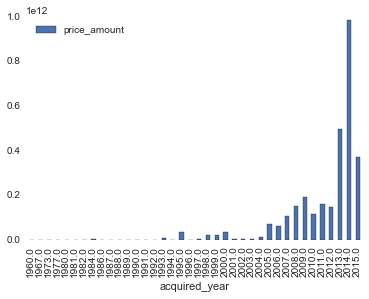

In [608]:
# Total price of acquisitions by year - Going up (big spike in 2013)

acquisitions.groupby("acquired_year").sum().plot(kind = "bar")

In [612]:
groups = acquisitions.groupby("company_country_code")

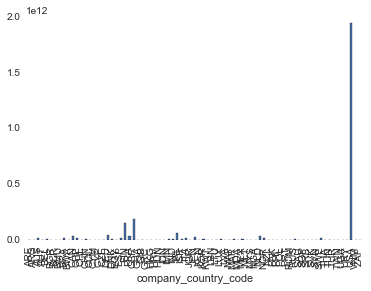

In [619]:
groups.aggregate(np.sum).iloc[:,1].plot(kind = "bar")

In [ ]:
investments.columns

In [21]:
np.where(companies.name == "Mint")

(array([31086]),)

In [29]:
investments[investments.funding_round_code == "post_ipo_debt"]

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,...,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd


In [36]:
investments.columns

Index([u'company_permalink', u'company_name', u'company_category_list', u'company_market', u'company_country_code', u'company_state_code', u'company_region', u'company_city', u'investor_permalink', u'investor_name', u'investor_category_list', u'investor_market', u'investor_country_code', u'investor_state_code', u'investor_region', u'investor_city', u'funding_round_permalink', u'funding_round_type', u'funding_round_code', u'funded_at', u'funded_month', u'funded_quarter', u'funded_year', u'raised_amount_usd'], dtype='object')

In [39]:
investments[investments.funding_round_type == "angel"]

,company_permalink,company_name,company_category_list,company_market,company_country_code,company_state_code,company_region,company_city,investor_permalink,investor_name,...,investor_region,investor_city,funding_round_permalink,funding_round_type,funding_round_code,funded_at,funded_month,funded_quarter,funded_year,raised_amount_usd
238,/organization/google,Google,|Software|Video Streaming|Information Technolo...,Search,USA,CA,SF Bay Area,Mountain View,/person/andy-bechtolsheim,Andy Bechtolsheim,...,NaN,NaN,/funding-round/eb6c4d28ae50cd54ca55186d2955e8c3,angel,NaN,1998-08-01,1998-08,1998-Q3,1998,100000
297,/organization/wanted-technologies,WANTED Technologies,|Analytics|,Analytics,USA,NY,New York City,New York,/person/alain-ferland,Alain Ferland,...,NaN,NaN,/funding-round/03d5676cb7ebfb9b5636b4e93bc87394,angel,NaN,1999-01-01,1999-01,1999-Q1,1999,400000
298,/organization/wanted-technologies,WANTED Technologies,|Analytics|,Analytics,USA,NY,New York City,New York,/person/david-tanguay,David Tanguay,...,NaN,NaN,/funding-round/03d5676cb7ebfb9b5636b4e93bc87394,angel,NaN,1999-01-01,1999-01,1999-Q1,1999,400000
300,/organization/wanted-technologies,WANTED Technologies,|Analytics|,Analytics,USA,NY,New York City,New York,/person/evan-price,Evan Price,...,NaN,NaN,/funding-round/03d5676cb7ebfb9b5636b4e93bc87394,angel,NaN,1999-01-01,1999-01,1999-Q1,1999,400000
302,/organization/xanga,Xanga,|Curated Web|,Curated Web,USA,NY,New York City,New York,/person/greg-yaitanes,Greg Yaitanes,...,NaN,NaN,/funding-round/6dfb4613528afcb7d61ee2d4c064c29f,angel,NaN,1999-01-01,1999-01,1999-Q1,1999,NaN
310,/organization/wanted-technologies,WANTED Technologies,|Analytics|,Analytics,USA,NY,New York City,New York,/person/nick-merrick,Nick Merrick,...,NaN,NaN,/funding-round/03d5676cb7ebfb9b5636b4e93bc87394,angel,NaN,1999-01-01,1999-01,1999-Q1,1999,400000
323,/organization/hipbone,Hipbone,|Analytics|Customer Service|Software|,Software,USA,CA,SF Bay Area,San Carlos,/organization/band-of-angels,Band of Angels,...,SF Bay Area,Menlo Park,/funding-round/093cd6dbc74329cada1f011bb80f14f4,angel,NaN,1999-03-01,1999-03,1999-Q1,1999,750000
334,/organization/hipbone,Hipbone,|Analytics|Customer Service|Software|,Software,USA,CA,SF Bay Area,San Carlos,/organization/angel-investors-lp,Various Angel Investors,...,Los Angeles,Los Angeles,/funding-round/093cd6dbc74329cada1f011bb80f14f4,angel,NaN,1999-03-01,1999-03,1999-Q1,1999,750000
335,/organization/hipbone,Hipbone,|Analytics|Customer Service|Software|,Software,USA,CA,SF Bay Area,San Carlos,/person/eric-schmidt,Eric Schmidt,...,NaN,NaN,/funding-round/093cd6dbc74329cada1f011bb80f14f4,angel,NaN,1999-03-01,1999-03,1999-Q1,1999,750000
336,/organization/hipbone,Hipbone,|Analytics|Customer Service|Software|,Software,USA,CA,SF Bay Area,San Carlos,/person/ron-conway,Ron Conway,...,NaN,NaN,/funding-round/093cd6dbc74329cada1f011bb80f14f4,angel,NaN,1999-03-01,1999-03,1999-Q1,1999,750000


In [46]:
investments.columns

Index([u'company_permalink', u'company_name', u'company_category_list', u'company_market', u'company_country_code', u'company_state_code', u'company_region', u'company_city', u'investor_permalink', u'investor_name', u'investor_category_list', u'investor_market', u'investor_country_code', u'investor_state_code', u'investor_region', u'investor_city', u'funding_round_permalink', u'funding_round_type', u'funding_round_code', u'funded_at', u'funded_month', u'funded_quarter', u'funded_year', u'raised_amount_usd'], dtype='object')

In [47]:
acquisitions.columns

Index([u'company_permalink', u'company_name', u'company_category_list', u'company_market', u'company_country_code', u'company_state_code', u'company_region', u'company_city', u'acquirer_permalink', u'acquirer_name', u'acquirer_category_list', u'acquirer_market', u'acquirer_country_code', u'acquirer_state_code', u'acquirer_region', u'acquirer_city', u'acquired_at', u'acquired_month', u'acquired_quarter', u'acquired_year', u'price_amount', u'price_currency_code'], dtype='object')

In [48]:
rounds.columns

Index([u'company_permalink', u'company_name', u'company_category_list', u'company_market', u'company_country_code', u'company_state_code', u'company_region', u'company_city', u'funding_round_permalink', u'funding_round_type', u'funding_round_code', u'funded_at', u'funded_month', u'funded_quarter', u'funded_year', u'raised_amount_usd'], dtype='object')

In [49]:
companies.columns

Index([u'permalink', u'name', u'homepage_url', u'category_list', u'market', u'funding_total_usd', u'status', u'country_code', u'state_code', u'region', u'city', u'funding_rounds', u'founded_at', u'founded_month', u'founded_quarter', u'founded_year', u'first_funding_at', u'last_funding_at'], dtype='object')

In [59]:
Counter(companies[companies.status == "acquired"].funding_rounds)

Counter({1: 2107, 2: 1026, 3: 591, 4: 284, 5: 139, 6: 82, 7: 40, 8: 13, 9: 10, 10: 5, 11: 4, 15: 1})

In [26]:
companies.head()

,permalink,name,homepage_url,category_list,market,funding_total_usd,status,country_code,state_code,region,city,funding_rounds,founded_at,founded_month,founded_quarter,founded_year,first_funding_at,last_funding_at
0,/organization/-fame,#fame,http://livfame.com,|Media|,Media,10000000,operating,IND,NaN,Mumbai,Mumbai,1,NaN,NaN,NaN,NaN,2015-01-05 00:00:00,2015-01-05
1,/organization/hashoff,#HASHOFF,http://www.hashoff.com,|Digital Media|Internet|Social Media|,Digital Media,455000,operating,USA,CO,Denver,Denver,1,2014-04-01 00:00:00,2014-04,2014-Q2,2014,2014-12-08 00:00:00,2014-12-08
2,/organization/waywire,#waywire,http://www.waywire.com,|Entertainment|Politics|Social Media|News|,News,1750000,acquired,USA,NY,New York City,New York,1,2012-06-01 00:00:00,2012-06,2012-Q2,2012,2012-06-30 00:00:00,2012-06-30
3,/organization/tv-communications,&TV Communications,http://enjoyandtv.com,|Games|,Games,4000000,operating,USA,CA,Los Angeles,Los Angeles,2,NaN,NaN,NaN,NaN,2010-06-04 00:00:00,2010-09-23
4,/organization/rock-your-paper,'Rock' Your Paper,http://www.rockyourpaper.org,|Publishing|Education|,Publishing,40000,operating,EST,NaN,Tallinn,Tallinn,1,2012-10-26 00:00:00,2012-10,2012-Q4,2012,2012-08-09 00:00:00,2012-08-09


In [32]:
comp_pred = companies

In [33]:
comp_pred.columns

Index([u'permalink', u'name', u'homepage_url', u'category_list', u'market', u'funding_total_usd', u'status', u'country_code', u'state_code', u'region', u'city', u'funding_rounds', u'founded_at', u'founded_month', u'founded_quarter', u'founded_year', u'first_funding_at', u'last_funding_at'], dtype='object')

In [38]:
orgs_odm_df.columns

Index([u'crunchbase_uuid', u'primary_role', u'name', u'crunchbase_url', u'homepage_domain', u'homepage_url', u'facebook_url', u'twitter_url', u'linkedin_url', u'stock_symbol', u'location_city', u'location_region', u'location_country_code', u'short_description'], dtype='object')

In [39]:
Counter(orgs_odm_df.primary_role)

Counter({'company': 244652, 'school': 13653, 'investor': 13198, 'group': 2309, nan: 14, 'group ': 7, 'investor ': 2, 'School': 1, 'company ': 1, 'Company': 1})

In [ ]:
for company in companies.permalink:
    comp_name = company[14:]
    try:
        comp_api = cb.organization(comp_name)
    except:
        print "Error: " + comp_name
        continue
    orgs_api.insert(comp_api.data)

Error: 1000jobboersen-de
0:02:03.860596
Error: 3d-systems
Error: 58-com
Error: 5barz-international
Error: a-power-energy-generation
Error: abattis-bioceuticals
Error: abbott
Error: ablynx
Error: accelera-innovations
Error: accelerize-new-media
Error: access-pharmaceuticals
Error: acco-brands
Error: acorn-international
Error: acs-global
Error: actinium-pharmaceuticals
Error: activenetwork
Error: acusphere
Error: adaptive-media
Error: adcare-health-systems
Error: adslinked
Error: advanced-media
Error: aeropostale
Error: affymax
Error: agenus
Error: airspan-networks
Error: airtouch-communications
Error: alere
Error: alldigital
Error: allon-therapeutics
Error: altigen-communications
Error: altran
Error: ambient-corporation
Error: ambow-education
Error: american-addiction-centers
Error: american-apperal
Error: american-cannabis-company
Error: american-restaurant-concepts
Error: ampio-pharmaceuticals
Error: ampliphi-biosciences
Error: anavex
Error: anda
Error: anesiva
Error: envirosystems-i

In [5]:
# start where it was interrupted

for company in companies.permalink[31824:]:
    comp_name = company[14:]
    try:
        comp_api = cb.organization(comp_name)
    except:
        print "Error: " + comp_name
        continue
    orgs_api.insert(comp_api.data)

Error: morpho-technologies
Error: morphosys
Error: mrc-global-inc
Error: musclepharm
Error: mvb-bank
Error: naikun-wind-development
Error: nanocarrier-co
Error: nanotech-security
Error: nanoviricides
Error: nanya-technology-corporation
Error: nascent-biologics
Error: natcore-technology
Error: navidea-biopharmaceuticals
Error: neophotonics
Error: neovasc
Error: nephros
Error: neurogesx
Error: nevro
Error: nexgen-energy
Error: next-co
Error: nightingale-informatix-corporation
Error: noah
Error: north-american-palladium
Error: notify-technology
Error: novabay-pharmaceuticals-inc
Error: novelos-therapeutics
Error: nqmobile
Error: cytomedix
Error: nuvo-research
Error: oasmia-pharmaceutical
Error: ob1-2
Error: omni-bio-pharmaceutical
Error: omtool-ltd
Error: on-the-run-tech
Error: onemove-technologies
Error: oneroof-energy
Error: onstream-media
Error: opsens
Error: orad
Error: orbite-aluminae
Error: orckit-communications
Error: orexo
Error: organigram
Error: organovo-holdings
Error: palatin-

In [13]:
with open("errors.txt", "r") as f:
    errors = f.read()

In [18]:
company_errors = errors.replace("Error: ", "").split("\n")

In [70]:
# start where it was interrupted

for comp_name in company_errors:
    try:
        url = urlopen("https://api.crunchbase.com/v/3/organizations/" + comp_name + "?user_key=f724cd5232dd318067da50fd13ec28bc")
        data_string = url.read()
        json_file = json.loads(data_string)
    except:
        print "Error: " + comp_name
        continue
    orgs_api.insert(json_file["data"])

Error: 1000jobboersen-de
Error: adslinked
Error: asiansbook
Error: asktourism
Error: avis-2
Error: complex-media
Error: connect-hq
Error: contactpoint
Error: corenergy-infrastructure-trust
Error: corindus
Error: cormedix
Error: cortendo
Error: cortex-business-solutions
Error: crexendo
Error: shadowdcat-consulting
Error: freem?
Error: green-mountain-digital
Error: ?novatiff-reklam-ve-tan?t?m-hizmetleri-tic
Error: iproof---the-foundation-for-the-internet-of-things
Error: its-all-about-me
Error: klink-technologies
Error: knownact
Error: luma-legacy-2
Error: ob1-2
Error: on-the-run-tech
Error: patrof?n
Error: prod?ti-cz
Error: prze?wietl-pl
Error: socialchorus
Error: sociocast-networks
Error: soligenix
Error: somedia-bbn3
Error: spire-corporation
Error: spot-coffee
Error: spotlight-innovation
Error: sprylogics-international-corp
Error: talentsigned
Error: tutored-2
Error: vacation-bnb
Error: wavemaker-software
Error: whites-holdings
Error: whodats-spaces
